In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [ ]:
DB_CONFIG = {
    "dbname": "olist_db",
    "user": "postgres",
    "password": "YOUR_DB_PASSWORD",
    "host": "localhost",
    "port": 5432,
}

conn_string = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['dbname']}"
engine = create_engine(conn_string)

df_raw = pd.read_sql_table('seller_management', engine, schema='warehouse')
print(f"Đã tải xong {len(df_raw)} dữ liệu thô")

Đã tải xong 112064 dữ liệu thô


In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112064 entries, 0 to 112063
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   seller_id                      112064 non-null  object        
 1   order_id                       112064 non-null  object        
 2   product_id                     112064 non-null  object        
 3   order_status                   112064 non-null  object        
 4   order_purchase_timestamp       112064 non-null  datetime64[ns]
 5   order_approved_at              112049 non-null  datetime64[ns]
 6   order_delivered_carrier_date   111700 non-null  datetime64[ns]
 7   order_delivered_customer_date  110508 non-null  datetime64[ns]
 8   order_estimated_delivery_date  112064 non-null  datetime64[ns]
 9   shipping_limit_date            112064 non-null  datetime64[ns]
 10  review_score                   110553 non-null  float64       
 11  

In [4]:
df_raw.head()

,seller_id,order_id,product_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date,review_score,review_comment_message,price,freight_value
0,df560393f3a51e74553ab94004ba5c87,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,2017-02-13 13:57:51,5.0,Gostei pois veio no prazo determinado .,199.90,18.14
1,f4aba7c0bca51484c30ab7bdc34bcdd1,001d8f0e34a38c37f7dba2a37d4eba8b,e67307ff0f15ade43fcb6e670be7a74c,delivered,2017-05-14 17:19:44,2017-05-14 17:35:11,2017-05-24 15:45:01,2017-05-26 13:14:50,2017-05-24,2017-05-18 17:35:11,1.0,Entrega prometida 24/05/17. Dia 26/05/17 não h...,18.99,7.78
2,3340ef1913fb70d28420f6ceb685c339,001e7ba991be1b19605ca0316e7130f9,884fa3cd42986ba480ea2f8ae4e25ff7,delivered,2017-03-18 11:47:37,2017-03-18 11:47:37,2017-03-20 10:14:45,2017-03-28 14:23:33,2017-04-12,2017-03-23 11:47:37,5.0,,195.00,18.21
3,ff063b022a9a0aab91bad2c9088760b7,0020262c8a370bd5a174ea6a2a267321,a5341e3f8155dbb3e62323d3ea289729,delivered,2017-11-28 09:32:49,2017-11-28 09:58:07,2017-11-29 00:09:20,2017-12-02 12:27:33,2017-12-22,2017-12-04 09:58:07,4.0,,79.50,21.05
4,e8b4225284fbb02d16f200513f1f395d,00254baeb6c932b0a8aeead91fbd02b5,18901878788fec7ddc55e64d1ace8187,delivered,2018-05-08 21:45:54,2018-05-08 22:14:46,2018-05-09 13:51:00,2018-05-30 19:38:36,2018-06-05,2018-05-14 22:14:46,5.0,,149.90,43.11


In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = df_raw.copy()
seller_stats = df.groupby('seller_id').agg({
    'order_purchase_timestamp': 'max',  # Lấy ngày bán gần nhất
    'order_id': 'nunique'               # Đếm số đơn hàng duy nhất (Total Orders)
}).reset_index()

# Đổi tên cột 
seller_stats.columns = ['seller_id', 'last_sale_date', 'total_orders']

# Tính Recency (Số ngày kể từ lần bán cuối)
current_date = df['order_purchase_timestamp'].max()
seller_stats['days_since_last_sale'] = (current_date - seller_stats['last_sale_date']).dt.days

print(f"Tổng số Seller ban đầu: {len(seller_stats):,}")

Tổng số Seller ban đầu: 2,986



BẢNG PHÂN TÍCH TỶ LỆ ACTIVE THEO NGƯỠNG THỜI GIAN:
Ngưỡng (Ngày)   | Seller Còn lại  | Tỷ lệ (%)       | Đã loại bỏ     
Trong 30  ngày  | 1,210           | 40.5         % | 1,776          
Trong 60  ngày  | 1,586           | 53.1         % | 1,400          
Trong 90  ngày  | 1,781           | 59.6         % | 1,205          
Trong 120 ngày  | 1,932           | 64.7         % | 1,054          
Trong 180 ngày  | 2,150           | 72.0         % | 836            
Trong 365 ngày  | 2,618           | 87.7         % | 368            


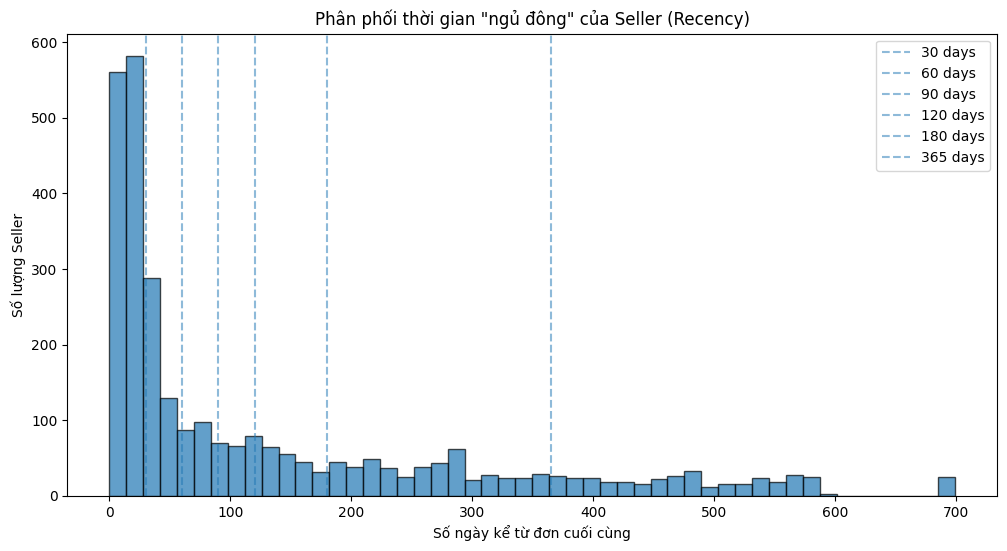

In [6]:
# PHÂN TÍCH RECENCY (CHURN) & TỶ LỆ CÒN LẠI

# Vẽ biểu đồ phân phối
plt.figure(figsize=(12, 6))
plt.hist(seller_stats['days_since_last_sale'], bins=50, color='#1f77b4', edgecolor='black', alpha=0.7)
plt.title('Phân phối thời gian "ngủ đông" của Seller (Recency)')
plt.xlabel('Số ngày kể từ đơn cuối cùng')
plt.ylabel('Số lượng Seller')

# Tạo bảng thống kê "Sức khỏe sàn" theo các ngưỡng
thresholds = [30, 60, 90, 120, 180, 365]
churn_analysis = []

total_sellers = len(seller_stats)

print("\nBẢNG PHÂN TÍCH TỶ LỆ ACTIVE THEO NGƯỠNG THỜI GIAN:")
print(f"{'Ngưỡng (Ngày)':<15} | {'Seller Còn lại':<15} | {'Tỷ lệ (%)':<15} | {'Đã loại bỏ':<15}")

for t in thresholds:
    # Đếm số seller có recency <= t (Vẫn active trong khoảng thời gian t)
    active_count = len(seller_stats[seller_stats['days_since_last_sale'] <= t])
    pct_active = (active_count / total_sellers) * 100
    dropped = total_sellers - active_count
    
    churn_analysis.append({
        'Threshold_Days': t,
        'Active_Sellers': active_count,
        'Pct_Active': pct_active
    })
    
    print(f"Trong {t:<3} ngày  | {active_count:<15,} | {pct_active:<13.1f}% | {dropped:<15,}")
    
    # Vẽ đường ngưỡng lên biểu đồ
    plt.axvline(x=t, linestyle='--', alpha=0.5, label=f'{t} days')

plt.legend()
plt.show()

In [7]:
# PHÂN TÍCH FREQUENCY (SỐ ĐƠN HÀNG)

print("PHÂN TÍCH SỐ LƯỢNG ĐƠN HÀNG (FREQUENCY)")

# 1. Xem phân vị (Quantiles) để tìm điểm cắt hợp lý
quantiles = seller_stats['total_orders'].quantile([0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print("\nPhân vị số đơn hàng (Top x% seller bán được bao nhiêu?):")
print(quantiles)

# 2. Đánh giá tác động của quy tắc loại bỏ theo số lượng đơn hàng
cutoff_check = 2
sellers_below_cutoff = len(seller_stats[seller_stats['total_orders'] < cutoff_check])
pct_impact = (sellers_below_cutoff / total_sellers) * 100

print(f"\nKIỂM TRA:")
print(f"Nếu loại bỏ Seller có dưới {cutoff_check} đơn hàng:")
print(f" -> Bạn sẽ loại bỏ: {sellers_below_cutoff:,} Seller")
print(f" -> Chiếm khoảng:   {pct_impact:.1f}% tổng số Seller trên sàn.")

if pct_impact > 30:
    print(" => CẢNH BÁO: Quy tắc này quá mạnh tay (loại bỏ >30% seller). Hãy cân nhắc giảm xuống 2 hoặc 3 đơn.")
else:
    print(" => Mức độ loại bỏ chấp nhận được.")

PHÂN TÍCH SỐ LƯỢNG ĐƠN HÀNG (FREQUENCY)

Phân vị số đơn hàng (Top x% seller bán được bao nhiêu?):
0.10      1.00
0.25      2.00
0.50      7.00
0.75     22.00
0.90     74.00
0.95    134.75
0.99    403.35
Name: total_orders, dtype: float64

KIỂM TRA:
Nếu loại bỏ Seller có dưới 2 đơn hàng:
 -> Bạn sẽ loại bỏ: 540 Seller
 -> Chiếm khoảng:   18.1% tổng số Seller trên sàn.
 => Mức độ loại bỏ chấp nhận được.


In [8]:
# TỔNG HỢP DỮ LIỆU TỪ RAW (Item/Order Level -> Seller Level)

print("Đang tổng hợp dữ liệu từ df_raw...")

# Xác định ngày hiện tại (Snapshot Date) là ngày cuối cùng có trong dữ liệu
current_date = df_raw['order_purchase_timestamp'].max()
print(f"Mốc thời gian hiện tại của dữ liệu: {current_date}")

# Group by seller_id để tính các chỉ số gốc
df_seller_stats = df_raw.groupby('seller_id').agg({
    'order_purchase_timestamp': ['min', 'max'], # Lấy ngày đầu tiên và ngày cuối cùng
    'order_id': 'nunique'                       # Đếm tổng số đơn hàng (Frequency)
}).reset_index()

# Làm phẳng MultiIndex (do dùng groupby agg list)
df_seller_stats.columns = ['seller_id', 'first_sale_date', 'last_sale_date', 'total_orders']


# TÍNH CÁC CỘT THỜI GIAN (Time Delta)

# Recency: Số ngày từ đơn cuối cùng đến hiện tại
df_seller_stats['days_since_last_sale'] = (current_date - df_seller_stats['last_sale_date']).dt.days

# Tenure (Thâm niên): Số ngày từ đơn đầu tiên đến hiện tại (dùng để xác định người mới)
df_seller_stats['days_since_first_sale'] = (current_date - df_seller_stats['first_sale_date']).dt.days

# Kiểm tra nhanh
print(f"Đã tạo bảng thống kê cho {len(df_seller_stats):,} Seller.")
display(df_seller_stats.head())

# ÁP DỤNG BỘ LỌC (FILTERING RULES)

# 1. Inactive: Không bán gì > 180 ngày VÀ Không phải người mới (> 60 ngày)
rule_inactive = (
    (df_seller_stats['days_since_last_sale'] > 180) & 
    (df_seller_stats['days_since_first_sale'] > 60)
)

# 2. Low Quality: Bán dưới 2 đơn VÀ Không phải người mới
rule_low_quality = (
    (df_seller_stats['total_orders'] < 2) & 
    (df_seller_stats['days_since_first_sale'] > 60)
)

# Tạo danh sách Seller cần loại bỏ và Seller giữ lại
sellers_to_drop = df_seller_stats[rule_inactive | rule_low_quality]
active_sellers_list = df_seller_stats[~ (rule_inactive | rule_low_quality)]['seller_id']

# Tạo DataFrame df_active chứa dữ liệu raw NHƯNG chỉ của các seller được giữ lại
df_active = df_raw[df_raw['seller_id'].isin(active_sellers_list)].copy()

# BÁO CÁO KẾT QUẢ

print("-" * 30)
print(f"Tổng số Seller ban đầu: {len(df_seller_stats):,}")
print(f"Số Seller bị loại bỏ:   {len(sellers_to_drop):,} ({len(sellers_to_drop)/len(df_seller_stats):.1%})")
print(f"Số Seller giữ lại:      {len(active_sellers_list):,} ({len(active_sellers_list)/len(df_seller_stats):.1%})")
print("-" * 30)
print("-> df_active đã sẵn sàng cho bước tính toán Vận hành.")

Đang tổng hợp dữ liệu từ df_raw...
Mốc thời gian hiện tại của dữ liệu: 2018-09-03 09:06:57
Đã tạo bảng thống kê cho 2,986 Seller.


,seller_id,first_sale_date,last_sale_date,total_orders,days_since_last_sale,days_since_first_sale
0,0015a82c2db000af6aaaf3ae2ecb0532,2017-09-26 22:17:05,2017-10-18 08:16:34,3,320,341
1,001cca7ae9ae17fb1caed9dfb1094831,2017-02-04 19:06:04,2018-07-12 21:38:26,200,52,575
2,002100f778ceb8431b7a1020ff7ab48f,2017-09-14 01:00:31,2018-04-12 12:58:23,51,143,354
3,003554e2dce176b5555353e4f3555ac8,2017-12-15 06:52:25,2017-12-15 06:52:25,1,262,262
4,004c9cd9d87a3c30c522c48c4fc07416,2017-01-27 10:34:34,2018-05-03 11:13:38,158,122,583


------------------------------
Tổng số Seller ban đầu: 2,986
Số Seller bị loại bỏ:   968 (32.4%)
Số Seller giữ lại:      2,018 (67.6%)
------------------------------
-> df_active đã sẵn sàng cho bước tính toán Vận hành.


In [9]:
import pandas as pd
import numpy as np
import re

def identify_logistics_bias(row):
    """
    Hàm trả về True nếu đánh giá thấp là do lỗi Vận chuyển (để loại bỏ).
    """
    # Chỉ xét các review tiêu cực (<= 3 sao)
    if row['review_score'] > 3:
        return False
        
    # Chuẩn hóa text (lowercase)
    comment = str(row['review_comment_message']).lower() if row['review_comment_message'] else ""
    
    #  1. LOGIC THỜI GIAN 
    # Shipper giao trễ cho khách
    seller_innocent = row['order_delivered_carrier_date'] <= row['shipping_limit_date']
    carrier_late = row['order_delivered_customer_date'] > row['order_estimated_delivery_date']
    
    is_time_fault = carrier_late and seller_innocent
    
    # 2. LOGIC NLP 
    
    # Bộ từ khóa liên quan đến Vận chuyển (Shipper/Delivery)
    keywords_shipping = [
        'atras', 'demor', 'entreg', 'correio', 'transport', 'aguard',
        'não receb', 'nao receb', 'não cheg', 'nao cheg', 'extravi','prazo'
    ]
    
    # Bộ từ khóa liên quan đến Hư hỏng ngoại quan (Damage)
    keywords_damage = [
        'danifi', 'quebr', 'amass', 'rasg', 'molha', 'abert', 'viola', 'caixa', 
        'embalagem', 'avaria' 
    ]
    
    # Kiểm tra xem comment có chứa từ khóa không
    has_shipping_complaint = any(kw in comment for kw in keywords_shipping)
    has_damage_complaint = any(kw in comment for kw in keywords_damage)
    
    # 3. QUYẾT ĐỊNH CUỐI CÙNG 
    
    # TH1: Khách chê giao chậm VÀ Thực tế có giao chậm -> Lỗi Logistics
    if has_shipping_complaint and is_time_fault:
        return True
        
    # TH2: Khách chê hàng nát/móp (thường do vận chuyển) -> Lỗi Logistics
    if has_damage_complaint:
        return True
        
    # TH3: Chỉ có Logic thời gian mà KHÔNG có comment (Khách vote 1 sao không lời)
    # -> Nếu giao trễ-> Coi là lỗi Logistics
    days_late = (row['order_delivered_customer_date'] - row['order_estimated_delivery_date']).total_seconds() / 86400
    if comment == "" and days_late > 0 and seller_innocent:
        return True

    return False

#  ÁP DỤNG 
print("Đang xử lý NLP đơn giản & Logic vận hành để lọc đánh giá...")

# Cần đảm bảo các cột ngày tháng đã là datetime
df_active['is_logistics_fault'] = df_active.apply(identify_logistics_bias, axis=1)

# Tạo cột điểm đã điều chỉnh (Adjusted Score)
# Nếu là lỗi logistics -> Gán NaN để không tính trung bình
df_active['adjusted_review_score'] = np.where(
    df_active['is_logistics_fault'], 
    np.nan, 
    df_active['review_score']
)

Đang xử lý NLP đơn giản & Logic vận hành để lọc đánh giá...


In [10]:
# 1. Tính toán các chỉ số thống kê
total_reviews = len(df_active)

# Đếm số review có comment (Loại bỏ giá trị NaN và chuỗi rỗng)
# Lưu ý: Cần astype(str) để tránh lỗi nếu cột comment có lẫn số
total_comments = (df_active['review_comment_message'].fillna('').astype(str).str.strip() != '').sum()

# Đếm tổng số review tiêu cực (<= 3 sao)
# Đây là "tập khách hàng mục tiêu" mà thuật toán nhắm tới
total_negative = (df_active['review_score'] <= 3).sum()

# Số lượng đã loại bỏ
removed_count = df_active['is_logistics_fault'].sum()

# 2. In báo cáo chi tiết
print("\n" + "="*50)
print("HIỆU QUẢ LỌC BIAS VẬN CHUYỂN")
print("="*50)
print(f"1. Tổng số dòng dữ liệu (Reviews):   {total_reviews:,}")
print(f"2. Số lượng Review có nội dung chữ:  {total_comments:,} (Chiếm {total_comments/total_reviews:.1%})")
print(f"3. Tổng số Review Tiêu cực (<=3*):   {total_negative:,}")
print("-" * 50)
print(f"KẾT QUẢ: Đã loại bỏ cho {removed_count:,} trường hợp.")
print(f" -> Tỷ lệ trên TỔNG dữ liệu:         {removed_count/total_reviews:.2%}")
print(f" -> Tỷ lệ trên Review CÓ COMMENT:    {removed_count/total_comments:.2%}")
print(f" -> Tỷ lệ trên Review TIÊU CỰC:      {removed_count/total_negative:.1%}")
print("="*50)


HIỆU QUẢ LỌC BIAS VẬN CHUYỂN
1. Tổng số dòng dữ liệu (Reviews):   104,492
2. Số lượng Review có nội dung chữ:  43,522 (Chiếm 41.7%)
3. Tổng số Review Tiêu cực (<=3*):   24,612
--------------------------------------------------
KẾT QUẢ: Đã loại bỏ cho 4,449 trường hợp.
 -> Tỷ lệ trên TỔNG dữ liệu:         4.26%
 -> Tỷ lệ trên Review CÓ COMMENT:    10.22%
 -> Tỷ lệ trên Review TIÊU CỰC:      18.1%


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_ops = df_active.copy()

# TÍNH TOÁN TRÊN TỪNG ĐƠN HÀNG (ROW LEVEL)

# 1. Tính thời gian xử lý (Lead Time) ra đơn vị GIỜ
# Logic: Thời gian Carrier nhận - Thời gian duyệt đơn
df_ops['prep_time_hours'] = (df_ops['order_delivered_carrier_date'] - df_ops['order_approved_at']).dt.total_seconds() / 3600

# Xử lý nhiễu: 
# - Nếu prep_time < 0 (Dữ liệu lỗi, Carrier nhận trước khi Duyệt): Gán về 0 hoặc Median
# - Chỉ tính các đơn đã được giao cho Carrier (không tính đơn hủy/unavailable chưa xử lý)
df_ops = df_ops[df_ops['prep_time_hours'].notna()]
df_ops.loc[df_ops['prep_time_hours'] < 0, 'prep_time_hours'] = 0

# 2. Xác định đơn giao trễ (Late Shipment)
# Logic: Ngày Carrier nhận > Hạn chót (Shipping Limit)
# Lưu ý: shipping_limit_date trong Olist thường khá rộng, nên trễ mốc này là lỗi nặng.
df_ops['is_late_shipment'] = np.where(
    df_ops['order_delivered_carrier_date'] > df_ops['shipping_limit_date'], 
    1, 0
)

# TỔNG HỢP THEO SELLER 

seller_ops_features = df_ops.groupby('seller_id').agg({
    # Tỷ lệ giao hàng trễ (Trung bình của cột 0/1 chính là tỷ lệ %)
    'is_late_shipment': 'mean',
    
    # Thời gian xử lý trung bình (Dùng Median để kháng nhiễu)
    'prep_time_hours': 'median',
    
    # Tính thêm Độ lệch chuẩn (Std) để đo sự ổn định
    # Seller A: Luôn giao trong 24h (Tốt) vs Seller B: Lúc 2h, lúc 48h (Kém ổn định)
    # 'prep_time_hours': ['median', 'std'] # (Nếu muốn nâng cao)
}).reset_index()

# Đổi tên cột cho đẹp
seller_ops_features.columns = ['seller_id', 'late_shipment_rate', 'avg_prep_time_hours']

# Xử lý giá trị thiếu (nếu có)
# Thường ít khi null, nhưng cẩn thận vẫn hơn
seller_ops_features['late_shipment_rate'] = seller_ops_features['late_shipment_rate'].fillna(0)
seller_ops_features['avg_prep_time_hours'] = seller_ops_features['avg_prep_time_hours'].fillna(24.0) # Mặc định 24h nếu thiếu

print("Đã tính toán xong đặc trưng vận hành.")
display(seller_ops_features.head())

Đã tính toán xong đặc trưng vận hành.


,seller_id,late_shipment_rate,avg_prep_time_hours
0,001cca7ae9ae17fb1caed9dfb1094831,0.054393,40.124722
1,002100f778ceb8431b7a1020ff7ab48f,0.089286,65.101806
2,004c9cd9d87a3c30c522c48c4fc07416,0.000000,25.681528
3,00720abe85ba0859807595bbf045a33b,0.115385,43.819167
4,00ee68308b45bc5e2660cd833c3f81cc,0.011561,28.620556


Đang tổng hợp bảng đặc trưng cuối cùng (The 3 Pillars)...
Phát hiện 1 Seller thiếu dữ liệu vận hành (Prep time/Late rate).
Số lượng Seller sau khi loại bỏ:    2,017
------------------------------
BẢNG ĐẶC TRƯNG HOÀN CHỈNH:
<class 'pandas.core.frame.DataFrame'>
Index: 2017 entries, 0 to 2017
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   seller_id            2017 non-null   object 
 1   gmv                  2017 non-null   float64
 2   total_orders         2017 non-null   int64  
 3   avg_rating           2017 non-null   float64
 4   late_shipment_rate   2017 non-null   float64
 5   avg_prep_time_hours  2017 non-null   float64
 6   log_gmv              2017 non-null   float64
 7   log_orders           2017 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 141.8+ KB
None


,seller_id,gmv,total_orders,avg_rating,late_shipment_rate,avg_prep_time_hours,log_gmv,log_orders
0,001cca7ae9ae17fb1caed9dfb1094831,25080.03,200,4.045249,0.054393,40.124722,10.129867,5.303305
1,002100f778ceb8431b7a1020ff7ab48f,1254.40,51,4.235294,0.089286,65.101806,7.135210,3.951244
2,004c9cd9d87a3c30c522c48c4fc07416,20068.21,158,4.286624,0.000000,25.681528,9.906942,5.068904
3,00720abe85ba0859807595bbf045a33b,1007.50,13,3.653846,0.115385,43.819167,6.916219,2.639057
4,00ee68308b45bc5e2660cd833c3f81cc,20345.00,135,4.401198,0.011561,28.620556,9.920640,4.912655


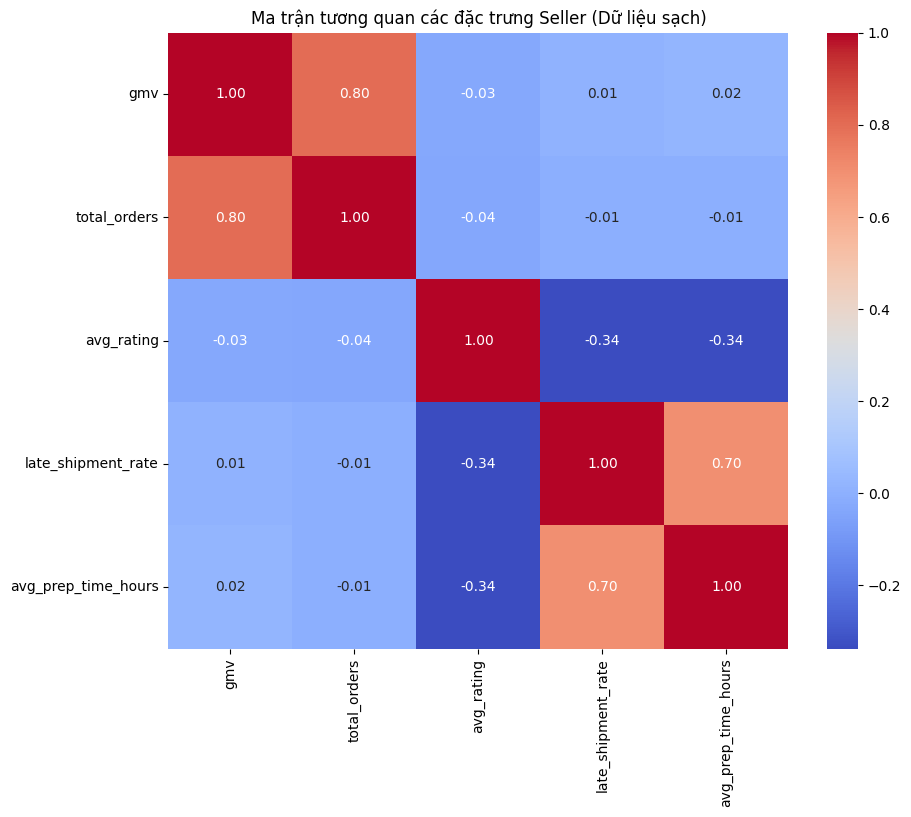

In [12]:
# TÍNH ĐẶC TRƯNG QUY MÔ (SCALE) & TỔNG HỢP CUỐI CÙNG
print("Đang tổng hợp bảng đặc trưng cuối cùng (The 3 Pillars)...")

# 1. Tính toán nhóm Quy mô và Chất lượng 
seller_scale_quality = df_active.groupby('seller_id').agg({
    'price': 'sum',            # Tổng doanh thu (GMV)
    'order_id': 'nunique',     # Tổng số đơn hàng thực tế (Sau khi lọc)
    
    # Điểm trung bình đã điều chỉnh
    'adjusted_review_score': 'mean' 
}).reset_index()

seller_scale_quality.rename(columns={
    'price': 'gmv',
    'order_id': 'total_orders',
    'adjusted_review_score': 'avg_rating'
}, inplace=True)

# 2. GHÉP CÁC BẢNG LẠI VỚI NHAU
df_final = seller_scale_quality.merge(seller_ops_features, on='seller_id', how='left')

# 3. XỬ LÝ GIÁ TRỊ THIẾU (MISSING VALUES) CUỐI CÙNG
missing_ops = df_final['avg_prep_time_hours'].isna() | df_final['late_shipment_rate'].isna()
print(f"Phát hiện {missing_ops.sum():,} Seller thiếu dữ liệu vận hành (Prep time/Late rate).")

# THỰC HIỆN LOẠI BỎ 
df_final = df_final.dropna(subset=['avg_prep_time_hours', 'late_shipment_rate'])

# Riêng avg_rating: Nếu Seller có bán hàng, có vận hành, nhưng CHƯA CÓ REVIEW
# Ta vẫn nên giữ lại và điền điểm trung bình (để không loại bỏ oan Seller mới làm tốt nhưng khách lười review)
global_avg_rating = df_final['avg_rating'].mean()
df_final['avg_rating'] = df_final['avg_rating'].fillna(global_avg_rating)

print(f"Số lượng Seller sau khi loại bỏ:    {len(df_final):,}")
print("-" * 30)

# 4. CHUẨN BỊ CHO MÔ HÌNH (LOG TRANSFORMATION)
df_final['log_gmv'] = np.log(df_final['gmv'] + 1)
df_final['log_orders'] = np.log(df_final['total_orders'] + 1)

# 5. KIỂM TRA KẾT QUẢ & TƯƠNG QUAN
print("BẢNG ĐẶC TRƯNG HOÀN CHỈNH:")
print(df_final.info())
display(df_final.head())

# Vẽ biểu đồ tương quan
plt.figure(figsize=(10, 8))
# Chỉ chọn các cột số liệu gốc để xem tương quan
cols_to_corr = ['gmv', 'total_orders', 'avg_rating', 'late_shipment_rate', 'avg_prep_time_hours']
sns.heatmap(df_final[cols_to_corr].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Ma trận tương quan các đặc trưng Seller (Dữ liệu sạch)")
plt.show()

TÌM TRỌNG SỐ

In [13]:
from sklearn.preprocessing import StandardScaler

# Lấy các cột đặc trưng
features = ['gmv', 'total_orders', 'avg_rating', 'late_shipment_rate', 'avg_prep_time_hours']

# Tạo dataframe X
X = df_final[features].copy()
X['gmv'] = np.log1p(X['gmv'])
X['total_orders'] = np.log1p(X['total_orders'])

# Chuẩn hóa về cùng scale (Mean=0, Std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Dữ liệu đã được chuẩn hóa.")

Dữ liệu đã được chuẩn hóa.


Đang tính toán các chỉ số đánh giá...
K=2: Silhouette=0.299, DBI=1.393
K=3: Silhouette=0.328, DBI=1.046
K=4: Silhouette=0.335, DBI=1.065
K=5: Silhouette=0.260, DBI=1.119
K=6: Silhouette=0.274, DBI=1.133
K=7: Silhouette=0.276, DBI=1.069
K=8: Silhouette=0.236, DBI=1.166
K=9: Silhouette=0.239, DBI=1.165
K=10: Silhouette=0.237, DBI=1.169


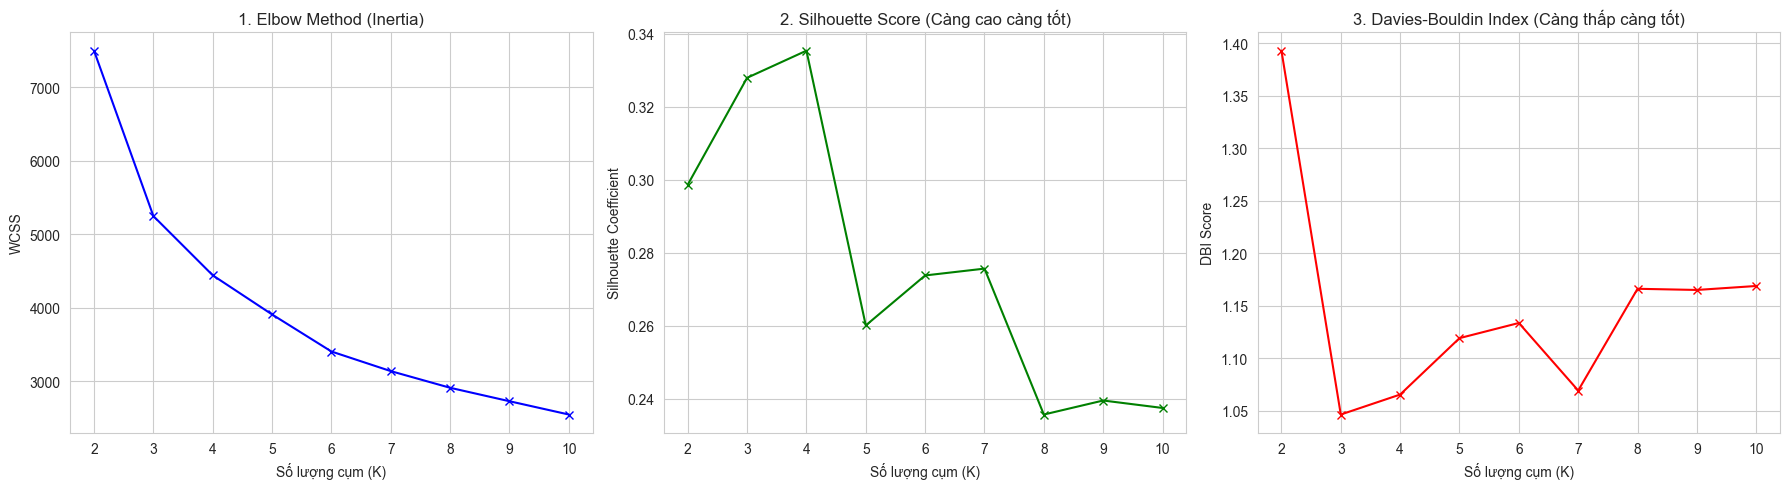

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Thiết lập style cho biểu đồ đẹp hơn
sns.set_style("whitegrid")

# Khởi tạo các list để lưu kết quả
wcss = []       # Inertia (Elbow Method)
sil_scores = [] # Silhouette Score
dbi_scores = [] # Davies-Bouldin Index

# Lưu ý: Silhouette và DBI cần ít nhất 2 cụm để tính toán
k_range = range(2, 11)

print("Đang tính toán các chỉ số đánh giá...")

for k in k_range:
    # 1. Huấn luyện mô hình
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    labels = kmeans.labels_
    
    # 2. Tính toán các chỉ số
    # Inertia (WCSS) - Càng nhỏ càng tốt (nhưng phải tìm điểm gập)
    wcss.append(kmeans.inertia_)
    
    # Silhouette Score - Càng gần 1 càng tốt (tách biệt rõ)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)
    
    # Davies-Bouldin Index - Càng nhỏ càng tốt (cụm gọn và xa nhau)
    dbi = davies_bouldin_score(X_scaled, labels)
    dbi_scores.append(dbi)
    
    print(f"K={k}: Silhouette={sil:.3f}, DBI={dbi:.3f}")

# VẼ BIỂU ĐỒ SO SÁNH (3 TRONG 1)
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Biểu đồ 1: Elbow Method (Inertia)
ax[0].plot(k_range, wcss, 'bx-')
ax[0].set_title('1. Elbow Method (Inertia)')
ax[0].set_xlabel('Số lượng cụm (K)')
ax[0].set_ylabel('WCSS')
ax[0].grid(True)

# Biểu đồ 2: Silhouette Score
ax[1].plot(k_range, sil_scores, 'gx-')
ax[1].set_title('2. Silhouette Score (Càng cao càng tốt)')
ax[1].set_xlabel('Số lượng cụm (K)')
ax[1].set_ylabel('Silhouette Coefficient')
ax[1].grid(True)

# Biểu đồ 3: Davies-Bouldin Index
ax[2].plot(k_range, dbi_scores, 'rx-')
ax[2].set_title('3. Davies-Bouldin Index (Càng thấp càng tốt)')
ax[2].set_xlabel('Số lượng cụm (K)')
ax[2].set_ylabel('DBI Score')
ax[2].grid(True)

plt.tight_layout()
plt.show()

In [15]:
# Giả sử chọn K=3
k = 3
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
df_final['cluster'] = kmeans.fit_predict(X_scaled)

# Xem trung bình các chỉ số của từng cụm để đặt tên (Profiling)
cluster_summary = df_final.groupby('cluster')[features].mean()
display(cluster_summary)

# Sắp xếp lại tên cụm theo thứ tự tốt dần (Ví dụ dựa trên GMV hoặc Rating)
# Logic: Cụm nào GMV cao nhất + Rating tốt nhất -> Rank 0 (hoặc Rank cao nhất)

,gmv,total_orders,avg_rating,late_shipment_rate,avg_prep_time_hours
cluster,,,,,
0,791.119072,6.316288,4.369698,0.034104,40.043517
1,5085.835250,26.631250,3.510802,0.534536,180.975812
2,13381.100649,102.024969,4.221271,0.074435,45.416260


In [16]:
# Giả sử chọn K=4 
k = 4
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
df_final['cluster'] = kmeans.fit_predict(X_scaled)

# Xem trung bình các chỉ số của từng cụm để đặt tên (Profiling)
cluster_summary = df_final.groupby('cluster')[features].mean()
display(cluster_summary)

# Sắp xếp lại tên cụm theo thứ tự tốt dần (Ví dụ dựa trên GMV hoặc Rating)
# Logic: Cụm nào GMV cao nhất + Rating tốt nhất -> Rank 0 (hoặc Rank cao nhất)

,gmv,total_orders,avg_rating,late_shipment_rate,avg_prep_time_hours
cluster,,,,,
0,861.262237,6.286184,3.452197,0.051912,46.337398
1,5271.296224,27.097902,3.539468,0.561703,189.906591
2,13483.943811,102.845283,4.240470,0.075607,45.357749
3,815.564632,6.587097,4.684623,0.032193,39.119854


Việc K=4 tách được nhóm Seller nhỏ thành hai phân khúc rõ rệt về chất lượng (Rating 4.68 vs 3.45) cung cấp tín hiệu 'Chất lượng' mạnh mẽ hơn cho mô hình Random Forest. Điều này giúp thuật toán nhận diện đúng tầm quan trọng của biến avg_review_score, đảm bảo hệ thống tính điểm cuối cùng không ưu tiên những Seller bán nhiều

C:\Users\vinhq\AppData\Local\Temp\ipykernel_36404\469446959.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette='viridis')


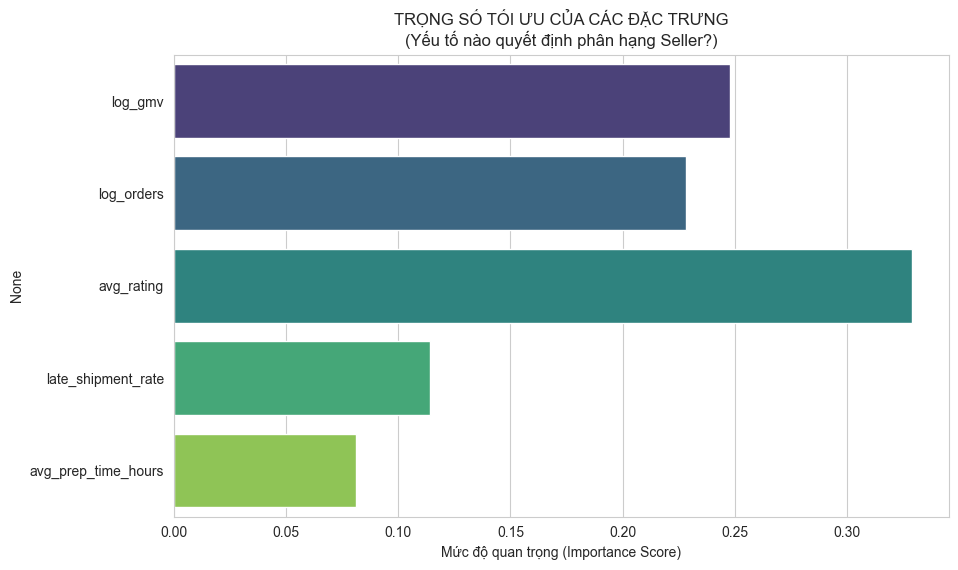

log_gmv             : 0.2478
log_orders          : 0.2281
avg_rating          : 0.3288
late_shipment_rate  : 0.1142
avg_prep_time_hours : 0.0812


In [17]:
from sklearn.ensemble import RandomForestClassifier

# Coi 'cluster' là nhãn mục tiêu
y = df_final['cluster']
# X là dữ liệu đầu vào (đã log transform nhưng chưa scale cũng được, cây quyết định không cần scale)
# Nhưng dùng X đã xử lý log cho tốt
X_rf = df_final[['log_gmv', 'log_orders', 'avg_rating', 'late_shipment_rate', 'avg_prep_time_hours']]

# Huấn luyện mô hình phân loại
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_rf, y)

# Lấy độ quan trọng (Feature Importances)
importances = rf_model.feature_importances_
feature_names = X_rf.columns

# Vẽ biểu đồ trọng số
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names, palette='viridis')
plt.title("TRỌNG SỐ TỐI ƯU CỦA CÁC ĐẶC TRƯNG\n(Yếu tố nào quyết định phân hạng Seller?)")
plt.xlabel("Mức độ quan trọng (Importance Score)")
plt.show()

# In ra con số cụ thể
for name, score in zip(feature_names, importances):
    print(f"{name:20s}: {score:.4f}")

--------------------------------------------------
BẢNG XẾP HẠNG SELLER (TOP 10):
--------------------------------------------------


,seller_id,gmv,total_orders,avg_rating,late_shipment_rate,final_score,segment
577,4869f7a5dfa277a7dca6462dcf3b52b2,229237.63,1131,4.357075,0.053680,92.058904,Platinum
998,7a67c85e85bb2ce8582c35f2203ad736,142265.51,1159,4.345536,0.026496,91.387469,Platinum
1625,cc419e0650a3c5ba77189a1882b7556a,104933.26,1697,4.188836,0.007299,90.658745,Platinum
1974,fa1c13f2614d7b5c4749cbc52fecda94,192553.33,582,4.524590,0.080617,90.489453,Platinum
822,6560211a19b47992c3666cc44a7e94c0,123057.82,1847,4.054140,0.004931,90.484167,Platinum
1209,955fee9216a65b617aa5c0531780ce60,135229.70,1286,4.186790,0.007343,90.479504,Platinum
1741,da8622b14eb17ae2831f4ac5b9dab84a,161299.57,1314,4.161854,0.049296,90.204749,Platinum
593,4a3ca9315b744ce9f8e9374361493884,201122.02,1804,3.921749,0.084797,89.389156,Platinum
801,620c87c171fb2a6dd6e8bb4dec959fc6,113719.10,731,4.398630,0.075853,89.150227,Platinum
1298,a1043bafd471dff536d0c462352beb48,101483.16,715,4.329685,0.006519,89.034484,Platinum



Phân bổ các nhóm:
segment
Bronze      505
Silver      504
Gold        504
Platinum    504
Name: count, dtype: int64


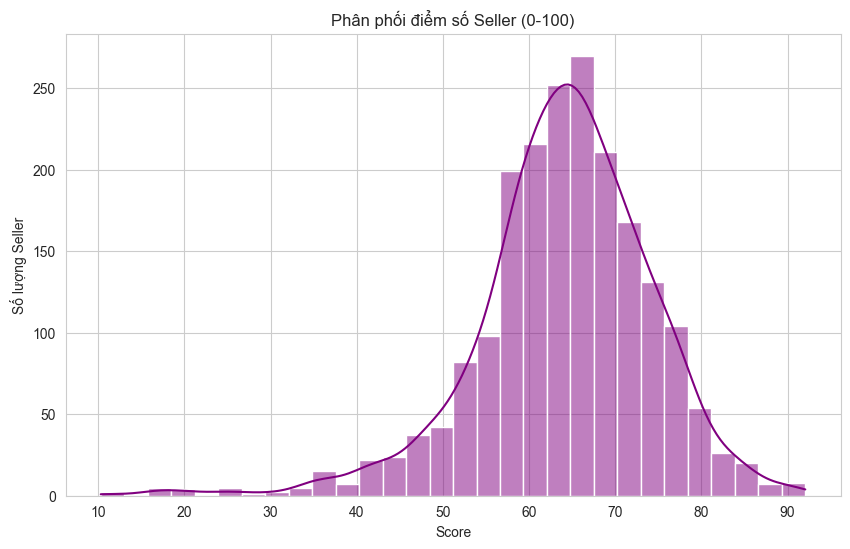

In [18]:
from sklearn.preprocessing import MinMaxScaler

# 1. Định nghĩa trọng số từ Random Forest (Lấy kết quả bạn vừa chạy)
weights = {
    'log_gmv': 0.2478,
    'log_orders': 0.2281,
    'avg_rating': 0.3288,
    'late_shipment_rate': 0.1142,
    'avg_prep_time_hours': 0.0812
}

# 2. Xử lý dữ liệu để tính điểm
# Copy để không ảnh hưởng bảng gốc
df_scoring = df_final.copy()

# Chuẩn hóa về 0-1 (MinMax) để nhân trọng số không bị lệch
scaler = MinMaxScaler()

# A. Nhóm thuận (Càng cao càng tốt)
positive_cols = ['log_gmv', 'log_orders', 'avg_rating']
df_scoring[positive_cols] = scaler.fit_transform(df_scoring[positive_cols])

# B. Nhóm nghịch (Càng thấp càng tốt) -> Cần đảo ngược: New_X = 1 - MinMax(X)
negative_cols = ['late_shipment_rate', 'avg_prep_time_hours']
# Scale trước
df_scoring[negative_cols] = scaler.fit_transform(df_scoring[negative_cols])
# Đảo ngược sau (Để 0 thành 1, 1 thành 0)
df_scoring['late_shipment_rate'] = 1 - df_scoring['late_shipment_rate']
df_scoring['avg_prep_time_hours'] = 1 - df_scoring['avg_prep_time_hours']

# 3. Tính điểm tổng hợp (Weighted Score)
df_final['final_score'] = (
    df_scoring['log_gmv'] * weights['log_gmv'] +
    df_scoring['log_orders'] * weights['log_orders'] +
    df_scoring['avg_rating'] * weights['avg_rating'] +
    df_scoring['late_shipment_rate'] * weights['late_shipment_rate'] +
    df_scoring['avg_prep_time_hours'] * weights['avg_prep_time_hours']
)

# Quy đổi về thang 100 cho đẹp (tùy chọn)
df_final['final_score'] = df_final['final_score'] * 100

# 4. Phân hạng Seller (Segmenting)
# Dùng qcut để chia theo phân vị (ví dụ: Top 20% là Platinum)
labels = ['Bronze', 'Silver', 'Gold', 'Platinum']
df_final['segment'] = pd.qcut(df_final['final_score'], q=4, labels=labels)

# 5. Hiển thị kết quả
print("-" * 50)
print("BẢNG XẾP HẠNG SELLER (TOP 10):")
print("-" * 50)
# Sắp xếp theo điểm cao nhất
top_sellers = df_final.sort_values(by='final_score', ascending=False).head(10)
display(top_sellers[['seller_id', 'gmv', 'total_orders', 'avg_rating', 'late_shipment_rate', 'final_score', 'segment']])

# Thống kê số lượng từng nhóm
print("\nPhân bổ các nhóm:")
print(df_final['segment'].value_counts())

# Vẽ biểu đồ phân phối điểm số
plt.figure(figsize=(10, 6))
sns.histplot(df_final['final_score'], bins=30, kde=True, color='purple')
plt.title('Phân phối điểm số Seller (0-100)')
plt.xlabel('Score')
plt.ylabel('Số lượng Seller')
plt.show()

PHÂN CỤM PHÂN BẬC -> TÌM GIẢI PHÁP HỖ TRỢ NGƯỜI BÁN

In [19]:
# TRÍCH XUẤT ĐẶC TRƯNG MÔ TẢ 
print("Đang trích xuất đặc trưng mô tả...")
    
df_cluster_raw = pd.read_sql_table('seller_segmentation', engine, schema='warehouse')

# 2. Chỉ giữ lại các Seller ĐÃ ĐƯỢC CHẤM ĐIỂM
if 'df_final' in locals():
    df_clustering = df_final[['seller_id']].merge(df_cluster_raw, on='seller_id', how='inner')
    df_clustering = df_clustering.dropna(subset=['avg_distance_km'])
    
    print("-" * 30)
    print("Dữ liệu sẵn sàng cho Phân cụm (Clustering):")
    print(df_clustering.info())
    display(df_clustering.head())
else:
    print(" Cảnh báo: Biến 'df_final' chưa tồn tại. Hãy chạy phần Scoring trước.")
    display(df_cluster_raw.head())

Đang trích xuất đặc trưng mô tả...
------------------------------
Dữ liệu sẵn sàng cho Phân cụm (Clustering):
<class 'pandas.core.frame.DataFrame'>
Index: 2015 entries, 0 to 2015
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   seller_id           2015 non-null   object 
 1   avg_weight_g        2015 non-null   float64
 2   category_diversity  2015 non-null   int64  
 3   market_reach        2015 non-null   int64  
 4   avg_distance_km     2015 non-null   float64
 5   avg_order_value     2015 non-null   float64
 6   avg_freight_ratio   2015 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 125.9+ KB
None


,seller_id,avg_weight_g,category_diversity,market_reach,avg_distance_km,avg_order_value,avg_freight_ratio
0,001cca7ae9ae17fb1caed9dfb1094831,8973.849372,2,17,811.848269,181.650821,0.365751
1,002100f778ceb8431b7a1020ff7ab48f,331.818182,1,13,530.165064,28.192000,0.764980
2,004c9cd9d87a3c30c522c48c4fc07416,2441.517647,2,18,648.995040,151.397949,0.194418
3,00720abe85ba0859807595bbf045a33b,525.000000,1,6,441.844794,159.800000,0.456243
4,00ee68308b45bc5e2660cd833c3f81cc,3157.796512,2,10,264.163109,239.718519,0.200856


In [20]:
df_clustering.describe()

,avg_weight_g,category_diversity,market_reach,avg_distance_km,avg_order_value,avg_freight_ratio
count,2015.000000,2015.000000,2015.000000,2015.000000,2015.000000,2015.000000
mean,2451.196469,2.478412,7.079901,600.821276,248.996685,0.308775
std,3770.074751,2.423897,5.646318,325.864405,917.190467,0.222079
min,50.000000,1.000000,1.000000,2.005829,9.990000,0.015733
25%,452.200000,1.000000,3.000000,402.960188,77.624857,0.159828
50%,1016.666667,2.000000,5.000000,552.003677,134.875000,0.256428
75%,2628.237613,3.000000,10.000000,735.569256,230.133571,0.395509
max,30000.000000,27.000000,27.000000,2798.982982,35733.750000,2.048777


1. Đang chuẩn bị dữ liệu...
   -> Dữ liệu đã được Log hóa và Chuẩn hóa.

2. Đang vẽ Dendrogram (Có thể mất 1-2 phút nếu dữ liệu lớn)...


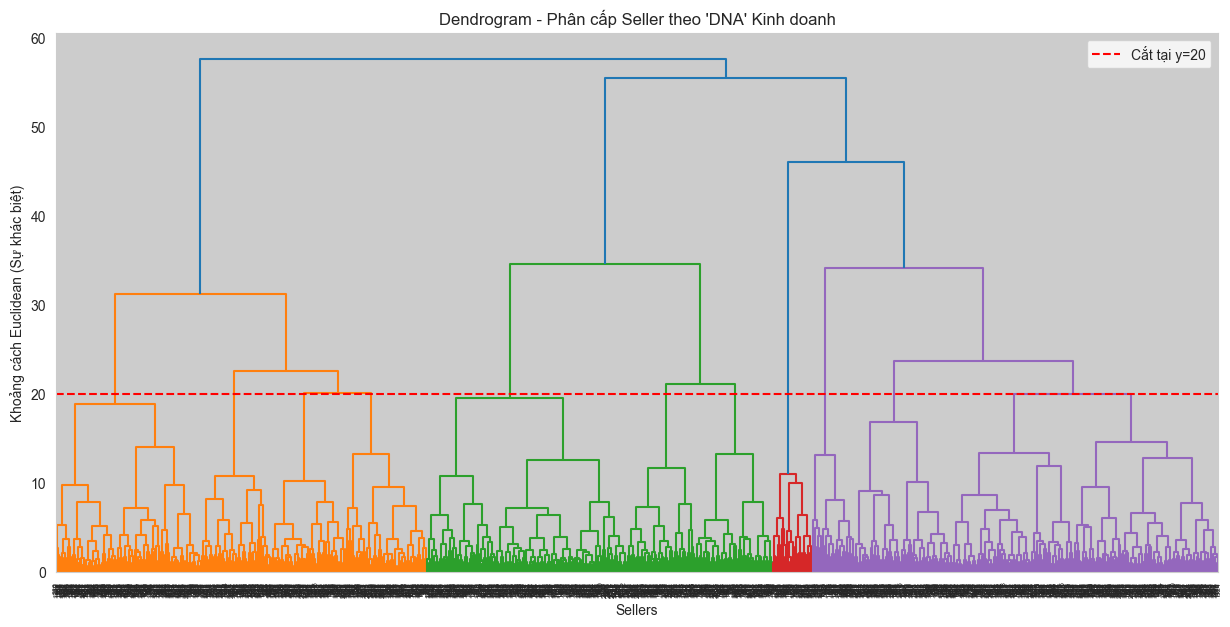

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

# CHUẨN BỊ DỮ LIỆU (PRE-PROCESSING)
print("1. Đang chuẩn bị dữ liệu...")

# Danh sách đặc trưng dùng để phân cụm
features = [
    'avg_weight_g', 
    'category_diversity', 
    'market_reach', 
    'avg_distance_km', 
    'avg_order_value', 
    'avg_freight_ratio'
]

# Tạo bản sao để xử lý
X_cluster = df_clustering[features].copy()

# A. Log Transformation (Cho các biến phân phối lệch)
# Dùng np.log1p để tránh lỗi log(0)
cols_to_log = [
    'avg_weight_g', 
    'category_diversity', 
    'market_reach', 
    'avg_distance_km', 
    'avg_order_value'
]

for col in cols_to_log:
    X_cluster[col] = np.log1p(X_cluster[col])

# B. Standard Scaling (Đưa về cùng hệ quy chiếu)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

print("   -> Dữ liệu đã được Log hóa và Chuẩn hóa.")


# VẼ DENDROGRAM (TÌM ĐIỂM CẮT K)
print("\n2. Đang vẽ Dendrogram (Có thể mất 1-2 phút nếu dữ liệu lớn)...")

plt.figure(figsize=(15, 7))
plt.title("Dendrogram - Phân cấp Seller theo 'DNA' Kinh doanh")
plt.xlabel('Sellers')
plt.ylabel('Khoảng cách Euclidean (Sự khác biệt)')

# method='ward': Giúp tối thiểu phương sai nội cụm (tạo các cụm tròn đều)
dendrogram = sch.dendrogram(sch.linkage(X_scaled, method='ward'))
suggested_cut_y = 20
plt.axhline(y=suggested_cut_y, color='r', linestyle='--', label=f'Cắt tại y={suggested_cut_y}')
plt.legend()
plt.show()

In [22]:
# THỰC HIỆN PHÂN CỤM (AGGLOMERATIVE CLUSTERING)
# Dựa vào Dendrogram, chọn số cụm k (n_clusters)
k = 7

print(f"\n3. Đang phân cụm với k={k}...")

hc_model = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='ward')
df_clustering['seller_cluster'] = hc_model.fit_predict(X_scaled)

# PHÂN TÍCH CHÂN DUNG (PROFILING)
print("-" * 50)
print("CHÂN DUNG CÁC NHÓM SELLER (PROFILE):")
print("(Giá trị trung bình thực tế - Không phải Log)")
print("-" * 50)

# Groupby theo cụm và tính trung bình các chỉ số GỐC (chưa log)
cluster_profile = df_clustering.groupby('seller_cluster')[features].mean().reset_index()

# Đếm số lượng seller mỗi cụm
cluster_counts = df_clustering['seller_cluster'].value_counts().reset_index()
cluster_counts.columns = ['seller_cluster', 'count']

# Gộp lại để xem tổng quan
profile_summary = cluster_profile.merge(cluster_counts, on='seller_cluster')
pd.options.display.float_format = '{:,.2f}'.format
display(profile_summary.sort_values(by='count', ascending=False))

# Gợi ý đặt tên (Tự động đoán dựa trên số liệu)
print("\n[GỢI Ý ĐẶT TÊN]:")
for i, row in profile_summary.iterrows():
    cluster_id = row['seller_cluster']
    desc = []
    
    if row['avg_order_value'] > profile_summary['avg_order_value'].mean() * 1.5:
        desc.append("High-Ticket (Giá cao)")
    elif row['avg_order_value'] < profile_summary['avg_order_value'].mean() * 0.7:
        desc.append("Low-Cost (Giá rẻ)")
        
    if row['avg_weight_g'] > profile_summary['avg_weight_g'].mean() * 1.5:
        desc.append("Bulky (Hàng nặng)")
    elif row['avg_weight_g'] < profile_summary['avg_weight_g'].mean() * 0.7:
        desc.append("Lightweight (Hàng nhẹ)")
        
    if row['market_reach'] > profile_summary['market_reach'].mean() * 1.5:
        desc.append("National (Toàn quốc)")
    else:
        desc.append("Local/Regional (Địa phương)")
        
    print(f"  - Cluster {int(cluster_id)}: {' + '.join(desc)}")


3. Đang phân cụm với k=7...
--------------------------------------------------
CHÂN DUNG CÁC NHÓM SELLER (PROFILE):
(Giá trị trung bình thực tế - Không phải Log)
--------------------------------------------------


,seller_cluster,avg_weight_g,category_diversity,market_reach,avg_distance_km,avg_order_value,avg_freight_ratio,count
0,0,825.61,1.65,5.38,634.73,98.95,0.36,631
1,1,"7,515.24",2.06,5.33,573.40,597.17,0.24,390
4,4,"1,913.87",2.53,12.19,658.81,227.39,0.21,348
6,6,"1,502.41",1.15,3.25,661.81,350.16,0.15,253
2,2,"1,189.66",7.02,13.29,566.51,107.88,0.40,252
5,5,535.93,1.64,4.12,602.98,64.66,1.01,72
3,3,"1,489.00",1.26,1.22,52.72,98.96,0.24,69



[GỢI Ý ĐẶT TÊN]:
  - Cluster 0: Low-Cost (Giá rẻ) + Lightweight (Hàng nhẹ) + Local/Regional (Địa phương)
  - Cluster 1: High-Ticket (Giá cao) + Bulky (Hàng nặng) + Local/Regional (Địa phương)
  - Cluster 2: Low-Cost (Giá rẻ) + Lightweight (Hàng nhẹ) + National (Toàn quốc)
  - Cluster 3: Low-Cost (Giá rẻ) + Lightweight (Hàng nhẹ) + Local/Regional (Địa phương)
  - Cluster 4: National (Toàn quốc)
  - Cluster 5: Low-Cost (Giá rẻ) + Lightweight (Hàng nhẹ) + Local/Regional (Địa phương)
  - Cluster 6: High-Ticket (Giá cao) + Local/Regional (Địa phương)


In [23]:
# THỰC HIỆN PHÂN CỤM (AGGLOMERATIVE CLUSTERING)
# Dựa vào Dendrogram, chọn số cụm k (n_clusters)
k = 12

print(f"\n3. Đang phân cụm với k={k}...")

hc_model = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='ward')
df_clustering['seller_cluster'] = hc_model.fit_predict(X_scaled)

# PHÂN TÍCH CHÂN DUNG (PROFILING)
print("-" * 50)
print("CHÂN DUNG CÁC NHÓM SELLER (PROFILE):")
print("(Giá trị trung bình thực tế)")
print("-" * 50)

# Groupby theo cụm và tính trung bình các chỉ số GỐC 
cluster_profile = df_clustering.groupby('seller_cluster')[features].mean().reset_index()

# Đếm số lượng seller mỗi cụm
cluster_counts = df_clustering['seller_cluster'].value_counts().reset_index()
cluster_counts.columns = ['seller_cluster', 'count']

# Gộp lại để xem tổng quan
profile_summary = cluster_profile.merge(cluster_counts, on='seller_cluster')

# Format hiển thị cho đẹp
pd.options.display.float_format = '{:,.2f}'.format
display(profile_summary.sort_values(by='count', ascending=False))

# Tự động đoán dựa trên số liệu
print("\n[ĐẶT TÊN]:")
for i, row in profile_summary.iterrows():
    cluster_id = row['seller_cluster']
    desc = []
    
    if row['avg_order_value'] > profile_summary['avg_order_value'].mean() * 1.5:
        desc.append("High-Ticket (Giá cao)")
    elif row['avg_order_value'] < profile_summary['avg_order_value'].mean() * 0.7:
        desc.append("Low-Cost (Giá rẻ)")
        
    if row['avg_weight_g'] > profile_summary['avg_weight_g'].mean() * 1.5:
        desc.append("Bulky (Hàng nặng)")
    elif row['avg_weight_g'] < profile_summary['avg_weight_g'].mean() * 0.7:
        desc.append("Lightweight (Hàng nhẹ)")
        
    if row['market_reach'] > profile_summary['market_reach'].mean() * 1.5:
        desc.append("National (Toàn quốc)")
    else:
        desc.append("Local/Regional (Địa phương)")
        
    print(f"  - Cluster {int(cluster_id)}: {' + '.join(desc)}")


3. Đang phân cụm với k=12...
--------------------------------------------------
CHÂN DUNG CÁC NHÓM SELLER (PROFILE):
(Giá trị trung bình thực tế)
--------------------------------------------------


,seller_cluster,avg_weight_g,category_diversity,market_reach,avg_distance_km,avg_order_value,avg_freight_ratio,count
0,0,"1,913.87",2.53,12.19,658.81,227.39,0.21,348
2,2,"1,502.41",1.15,3.25,661.81,350.16,0.15,253
3,3,"1,093.89",2.40,4.50,579.43,107.48,0.35,250
5,5,698.00,1.17,9.16,623.60,112.86,0.33,210
1,1,590.12,1.14,2.01,729.23,69.40,0.41,171
4,4,"5,871.69",1.24,3.94,533.56,199.44,0.33,140
6,6,"1,740.08",8.92,15.69,604.17,143.26,0.32,136
10,10,"6,562.14",3.52,7.39,582.50,318.65,0.25,130
8,8,"10,465.23",1.45,4.71,610.03,"1,362.93",0.14,120
9,9,544.34,4.80,10.48,522.36,66.39,0.49,116



[ĐẶT TÊN]:
  - Cluster 0: Lightweight (Hàng nhẹ) + National (Toàn quốc)
  - Cluster 1: Low-Cost (Giá rẻ) + Lightweight (Hàng nhẹ) + Local/Regional (Địa phương)
  - Cluster 2: Lightweight (Hàng nhẹ) + Local/Regional (Địa phương)
  - Cluster 3: Low-Cost (Giá rẻ) + Lightweight (Hàng nhẹ) + Local/Regional (Địa phương)
  - Cluster 4: Bulky (Hàng nặng) + Local/Regional (Địa phương)
  - Cluster 5: Low-Cost (Giá rẻ) + Lightweight (Hàng nhẹ) + Local/Regional (Địa phương)
  - Cluster 6: Low-Cost (Giá rẻ) + Lightweight (Hàng nhẹ) + National (Toàn quốc)
  - Cluster 7: Low-Cost (Giá rẻ) + Lightweight (Hàng nhẹ) + Local/Regional (Địa phương)
  - Cluster 8: High-Ticket (Giá cao) + Bulky (Hàng nặng) + Local/Regional (Địa phương)
  - Cluster 9: Low-Cost (Giá rẻ) + Lightweight (Hàng nhẹ) + National (Toàn quốc)
  - Cluster 10: Bulky (Hàng nặng) + Local/Regional (Địa phương)
  - Cluster 11: Low-Cost (Giá rẻ) + Lightweight (Hàng nhẹ) + Local/Regional (Địa phương)


Nhóm VIP (Cần chăm sóc kỹ nhất):

Cluster 8: "Big Whales" - Hàng rất nặng, Giá siêu cao (AOV ~1362).

Cluster 10: "Premium Heavy" - Hàng nặng, Giá cao (AOV ~318).

Nhóm Chủ Lực (Backbone):

Cluster 6: "National Generalist" - Bán đủ thứ (Diversity ~9), phủ sóng toàn quốc (Reach ~16).

Cluster 0: "Standard National" - Hàng trung bình, phủ sóng tốt (Reach ~12).

Nhóm Chuyên Biệt (Niche):

Cluster 2: "Niche High-Value" - Ít đa dạng (1.15), nhưng giá trị đơn khá (350), bán tập trung.

Nhóm Có Vấn Đề (Cần tối ưu Logistics):

Cluster 11: "Inefficient Cheap" - Bán đồ quá rẻ (64) khiến phí ship ăn hết lợi nhuận (Ratio 1.01).

Cluster 7: "Hyper Local" - Chỉ bán quanh nhà (52km), có thể là mô hình kinh doanh đặc thù

Dữ liệu tổng hợp:


,seller_id,gmv,total_orders,avg_rating,late_shipment_rate,avg_prep_time_hours,log_gmv,log_orders,cluster,final_score,segment,seller_cluster
0,001cca7ae9ae17fb1caed9dfb1094831,"25,080.03",200,4.05,0.05,40.12,10.13,5.30,2,78.43,Platinum,0
1,002100f778ceb8431b7a1020ff7ab48f,"1,254.40",51,4.24,0.09,65.10,7.14,3.95,2,67.64,Gold,5
2,004c9cd9d87a3c30c522c48c4fc07416,"20,068.21",158,4.29,0.00,25.68,9.91,5.07,2,79.85,Platinum,0
3,00720abe85ba0859807595bbf045a33b,"1,007.50",13,3.65,0.12,43.82,6.92,2.64,0,57.84,Bronze,5
4,00ee68308b45bc5e2660cd833c3f81cc,"20,345.00",135,4.40,0.01,28.62,9.92,4.91,2,80.14,Platinum,8


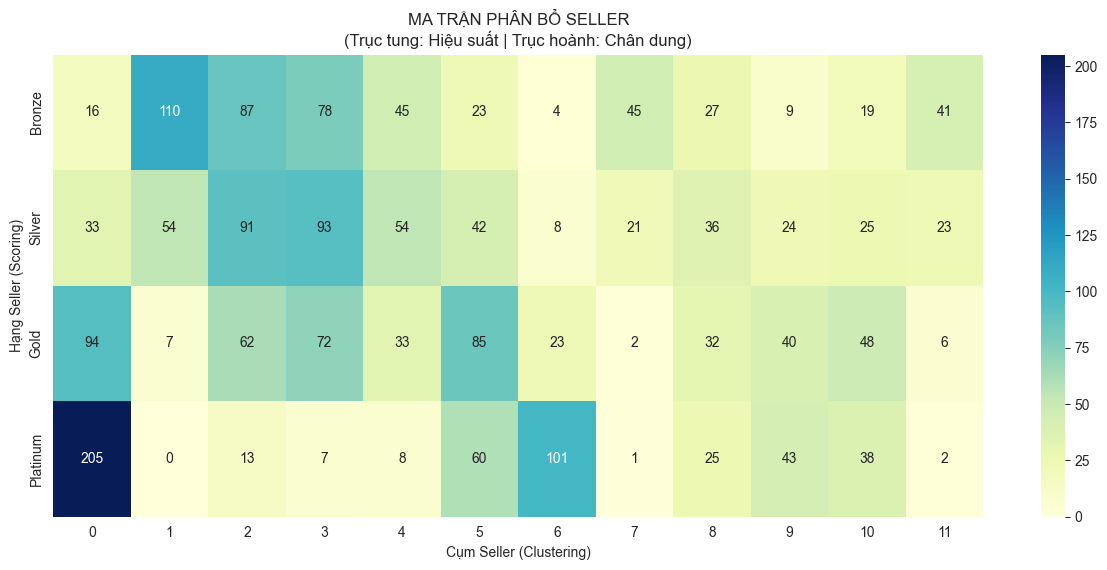

C:\Users\vinhq\AppData\Local\Temp\ipykernel_36404\385866615.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='seller_cluster', y='final_score', data=df_matrix, palette='Set3')


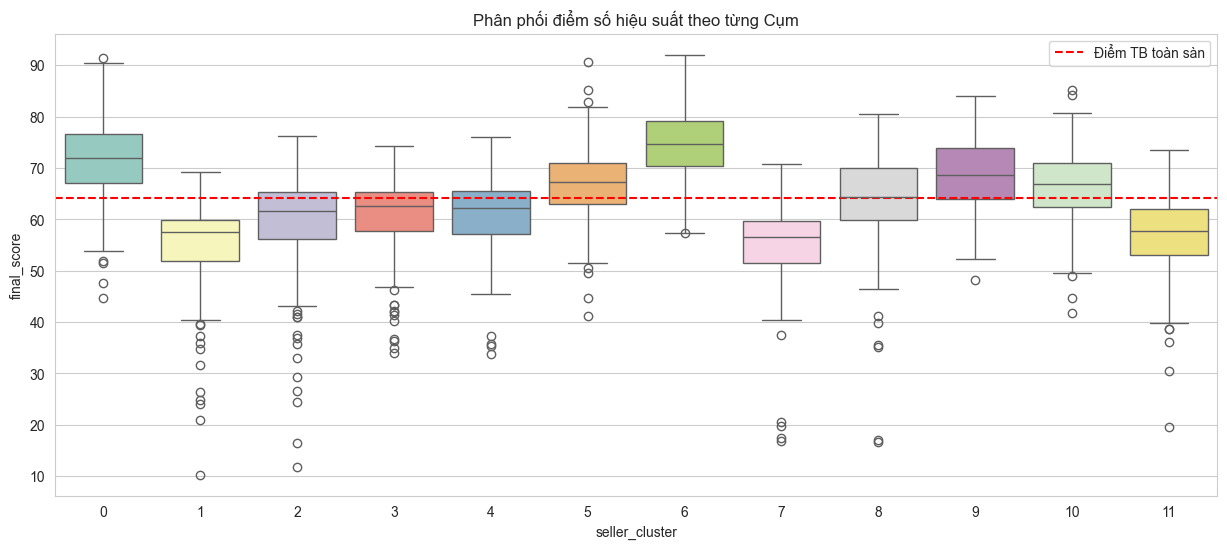

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# GHÉP DỮ LIỆU (MERGE)
# df_final: Chứa kết quả chấm điểm (final_score, segment)
# df_clustering: Chứa kết quả phân cụm (seller_cluster)

# Chỉ lấy cột cần thiết để merge
cluster_result = df_clustering[['seller_id', 'seller_cluster']]

# Merge
df_matrix = df_final.merge(cluster_result, on='seller_id', how='inner')

print("Dữ liệu tổng hợp:")
display(df_matrix.head())

# TẠO MA TRẬN PHÂN BỔ (HEATMAP)
# Tạo bảng chéo: Hàng là Segment (Rank), Cột là Cluster (Persona)
# Đếm số lượng seller trong từng ô
crosstab = pd.crosstab(df_matrix['segment'], df_matrix['seller_cluster'])

plt.figure(figsize=(15, 6))
# Vẽ Heatmap
sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlGnBu')
plt.title('MA TRẬN PHÂN BỔ SELLER\n(Trục tung: Hiệu suất | Trục hoành: Chân dung)')
plt.ylabel('Hạng Seller (Scoring)')
plt.xlabel('Cụm Seller (Clustering)')
plt.show()

# PHÂN TÍCH ĐIỂM SỐ THEO TỪNG CỤM (BOXPLOT)
plt.figure(figsize=(15, 6))
sns.boxplot(x='seller_cluster', y='final_score', data=df_matrix, palette='Set3')
plt.title('Phân phối điểm số hiệu suất theo từng Cụm')
plt.axhline(y=df_matrix['final_score'].mean(), color='r', linestyle='--', label='Điểm TB toàn sàn')
plt.legend()
plt.show()

In [26]:
import sys
import os
from datetime import datetime
sys.path.append('D:/do_an/Olist_seller_management/src')
import config
from data_loading import upload_to_gcs, load_gcs_to_bigquery

# Lưu tạm kết quả ra CSV ở local
today = datetime.now().strftime("%Y%m%d")
local_filename = f"seller_evaluation_{today}.csv"
df_matrix.to_csv(local_filename, index=False)

# Upload lên GCS
cloud_path = f"{config.GCS_FOLDER_PATH}{local_filename}"
upload_to_gcs(local_filename, cloud_path)

# Load vào Big Query
gcs_uri = f"gs://{config.GCS_BUCKET_NAME}/{cloud_path}"
load_gcs_to_bigquery(gcs_uri, 'olist_analytics', 'seller_scorecard')

print("Hoàn thành đánh giá + lưu trữ trên cloud")

2026-01-25 22:38:36,097 - INFO - Uploading seller_evaluation_20260125.csv to gs://olist-seller-evaluation/seller_reports/seller_evaluation_20260125.csv...
2026-01-25 22:38:38,708 - INFO - Upload to GCS successful!
2026-01-25 22:38:38,745 - INFO - Loading gs://olist-seller-evaluation/seller_reports/seller_evaluation_20260125.csv into BigQuery table my-test-project-473314.olist_analytics.seller_scorecard...
2026-01-25 22:38:42,875 - INFO - BigQuery Load Success! Loaded 2015 rows into seller_scorecard.


Hoàn thành đánh giá + lưu trữ trên cloud
